In [1]:
# load required packages
import nltk
from nltk.corpus import PlaintextCorpusReader
import pandas as pd
import re
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.cluster import KMeans
import time
import random

[nltk_data] Downloading package stopwords to C:\Users\Mr.
[nltk_data]     Priyan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining Functions

In [2]:
def print_cluster(df, km, num_clusters, cluster_level, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')

        for ind in range(0,num_cluster_topics): # top 6 words per cluster
            print(' %s' % unstem(terms[order_centroids[i,ind]]), end=',')
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [3]:
def save_topics(df, km, num_clusters, cluster_level, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            for ind in range(0,num_cluster_topics):                    
                topics_list.append(unstem(terms[order_centroids[i,ind]]))        
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict
        
    
        
        

In [4]:
def find_number_clusters(tfidf):
    wcss = []
    start = time.time()
    for i in range(1, 10):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 10)
        kmeans.fit(tfidf)
        wcss.append(kmeans.inertia_)
    end = time.time()
    print("execution time:",round(((end-start)/60),2),"minutes")
    plt.plot(range(1, 10), wcss)
    plt.title('The Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()  

In [5]:
def apply_kmeans(num_clusters,random_state,tfidf):
    km = KMeans(n_clusters=num_clusters, random_state =random_state)
    km.fit(tfidf)
    clusters = km.labels_.tolist()
    return km,clusters

In [6]:
def freq_words(indexes,new_corpus,terms,X):
    cluster_descriptions=""
    for i in (indexes):
        cluster_descriptions = cluster_descriptions+new_corpus[i]+" "
    cluster_descriptions=cluster_descriptions[:-1]
    from collections import Counter
    Counter = Counter(cluster_descriptions.split())
    #freq_words has most commonly occuring words within parent cluster ranked in descending order
    freq_words=Counter.most_common()
    # freq_terms has most commonly occuring terms(from tfidf matrix) within parent cluster ranked in descending order along with 
    #frequencies
    freq_terms_with_count = []
    for word in freq_words:
        if word[0] in set(terms):
            freq_terms_with_count.append(word)
    #sorted list of most occuring terms in cluster 3 , subcluster 1
    freq_terms = []
    for i in range(len(freq_terms_with_count)):
        freq_terms.append(freq_terms_with_count[i][0])
    # top X most occuring terms from that cluster
    # here is where you can play around with the X value
    X_freq_terms=freq_terms[0:X]
    return X_freq_terms, freq_terms_with_count   

In [7]:
def print_cluster_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=3, num_cluster_companies=2) :
    
    print("Top terms per cluster:")
    print()
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
    for i in range(num_clusters):
        print("Cluster %d words:" % int(i), end='')        
        flag=0
        ind=0
        while flag < num_cluster_topics: # top n words per cluster
            check_word = terms[order_centroids[i,ind]]
            if check_word not in set(words):
                print(' %s' % unstem(check_word), end=',')
                flag=flag+1
                ind = ind+1
            else:
                ind = ind+1
                    
        print() #add whitespace
        print() #add whitespace

        print("Cluster %d Companies:" % int(i), end='')
        #print()
        for title in df[df[cluster_level]==i]["Company"].sample(num_cluster_companies).values.tolist():
            print(' %s,' % title, end='')
            #uncomment below to see the Sector and Industry of each Company
            #print("Sector:",merged_df.Sector[merged_df.Company==title].values[0],"Industry:",merged_df.Industry[merged_df.Company==title].values[0])
        print() #add whitespace
        print() #add whitespace

    print("Split of classes within clusters:")
    print(df[cluster_level].value_counts())
    

In [8]:
def save_topics_words(df, km, num_clusters, cluster_level, words, num_cluster_topics=10) :
    
    if cluster_level=='Clusters':
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag=0
            ind=0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                if check_word not in set(words):
                    topics_list.append(unstem(check_word))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            topics_dict.update({str(i):topics_list})    
        return topics_dict
    
    if cluster_level=='Subclusters_level_1':
        level1= df['Clusters'].unique()[0]
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:                    
                check_word = terms[order_centroids[i,ind]]
                if check_word not in set(words):
                    topics_list.append(unstem(check_word))
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(i):topics_list})
        return topics_dict
    
    if cluster_level=='Subclusters_level_2':
        level1= int(df['Clusters'].unique()[0])
        level2 =int(df['Subclusters_level_1'].unique()[0]) 
        topics_dict = {}
        order_centroids = km.cluster_centers_.argsort()[:, ::-1] 
        for i in range(num_clusters):
            topics_list = []
            flag = 0
            ind = 0
            while flag<num_cluster_topics:
                check_word = terms[order_centroids[i,ind]]
                if check_word not in set(words):
                    topics_list.append(unstem(check_word)) 
                    flag = flag + 1
                    ind = ind + 1
                else:
                    ind = ind + 1
            
            topics_dict.update({str(level1)+str(level2)+str(i):topics_list})
        return topics_dict 
    
        

In [14]:
# function to unstem the words
def unstem(words,stemmed_vocab = stemmed_vocab):
    words = words.split()
    words = [stemmed_vocab['words'][word][:1][0] for word in words]
    return ' '.join(words)

## Reading from the text files to create corpus

In [10]:
#change path below to folder where you place the files
corpus_path = "C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_profiles" 
corpus = PlaintextCorpusReader(corpus_path, ".*\.txt")
print("Company Profile Corpus Statistics")
print("Number of profiles: " + str(len(corpus.fileids())))
print("Number of paragraphs: " + str(len(corpus.paras())))
print("Number of sentences: " + str(len(corpus.sents())))
print("Number of words: " + str(len(corpus.words())))

Company Profile Corpus Statistics
Number of profiles: 3558
Number of paragraphs: 3558
Number of sentences: 23988
Number of words: 790836


Changing to list of lists

In [115]:
list_corpus = []
#Converting corpus to list of lists
for company_description in corpus.fileids():
    list_corpus.append(list(corpus.words(company_description)))

## Preprocessing the corpus

Creating list of common words to later remove from the corpus

In [116]:
common_words = ['product','products','service','services','solution','solutions','segment','segments','offering','offerings',\
                'market','markets','provide','provides','provided','industry','industries','sells','sell','sold','state',\
                'states','headquarter','headquarters','headquartered', 'canada', 'california','texas','america','management',\
               'manages','manage', 'management','business','businesses','operation','operations','state','states',\
                'subsidiary','subsidiaries','approximate','approximately','group','groups','include','including','includes',\
                'base','bases','location','locations','use','uses','store','stores','unit','units','item','items',\
                'outlet','outlets','offer','offers','process','processes','processing','corporation','corporate','custom',\
               'offering','offerings','operate','operations','new york','africa','canada','america','international',\
                'manufacture','manufactures','manufacturer','manufacturers','brand','brands','benefit','benefits','customer',\
                'customers','industry','industries','firm','firms','commercial','commercials','com','new','speciality',\
                'specialities','used','unity','manufacturing','united','produce','produces','operates','operator','industrial',\
                'sales','company','companies','europe', 'asia','americas','middle east','sector','sectors','together',\
                'operators','production','productions','sale','private','public'\
               ]      
               
# to see the common words sorted in order
common_words.sort() 
#common_words      
               

 Pre-Processing Steps :-
- Removing punctuation
- Converting to lowercase
- Stemming
- Removing stop words
- Removing common words

In [145]:
# Preprocessing
#commenting everything as I had already all lists after the first time. 
## new_corpus : Stores the final corpus
## corpus_tokenized : stores all the words of the final corpus
## corpus_stemmed : stores all the stemmed words of the final corpus

start = time.time()

new_corpus = [] 
corpus_tokenized = []
corpus_stemmed=[]
for descriptions in list_corpus:
    #remove punctuation
    descriptions = re.sub('[^a-zA-Z]', ' ', str(descriptions))
    #convert all to lowercase
    descriptions = descriptions.lower()
    descriptions = descriptions.split()
    descriptions_copy = list(descriptions)
    #stemming
    ps = PorterStemmer()
    descriptions=[ps.stem(word) for word in descriptions if not word in set(stopwords.words('english')) if not word in set(common_words)]
    descriptions_copy=[word for word in descriptions_copy if not word in set(stopwords.words('english')) if not word in set(common_words)]
    corpus_tokenized.extend(descriptions_copy)
    corpus_stemmed.extend(descriptions)    
    descriptions = ' '.join(descriptions)
    new_corpus.append(descriptions)

end = time.time()
print("execution time:",round(((end-start)/60),2),"minutes")    


execution time: 16.57 minutes


In [149]:
# to store the new_corpus,corpus_tokenized,corpus_stemmed lists instead of having to run it each time 
#%store new_corpus
#%store corpus_tokenized
#%store corpus_stemmed


Stored 'new_corpus' (list)
Stored 'corpus_tokenized' (list)
Stored 'corpus_stemmed' (list)


In [11]:
#restoring new_corpus,corpus_tokenized,corpus_stemmed which was stored already
%store -r 

In [12]:
# Creating a data frame to reference stemmed words with actual words
stemmed_vocab = pd.DataFrame({'words': corpus_tokenized}, index = corpus_stemmed)
# removing duplicate indices, keeping the first index and removing all other duplicates, can also use 'last'
#stemmed_vocab = stemmed_vocab[~stemmed_vocab.index.duplicated(keep='first')]

In [13]:
#checking the content of a random document from new_corpus and comparing it to original description
rand_num = random.randrange(1,3559,1)
print("Original description:")
print(' '.join(corpus.words(corpus.fileids()[rand_num])))
print()
print("After pre-processing:")
print(new_corpus[rand_num])
print()

Original description:
ServiceMaster Global Holdings , Inc . provides residential and commercial services in the United States . The company operates through three segments : Terminix , American Home Shield , and the Franchise Services Group . The Terminix segment offers termite and pest control services , including termite remediation , annual termite inspection , and prevention treatments with damage claim guarantees , periodic pest control services , insulation services , mosquito control , crawlspace encapsulation , and wildlife exclusion . The American Home Shield segment provides home service plans that cover the repair or replacement of household systems and appliances , such as electrical , plumbing , central heating and air conditioning systems , water heaters , refrigerators , dishwashers , and ranges / ovens / cooktops . The Franchise Services Group segment offers disaster restoration , janitorial , residential cleaning , cabinet and wood furniture repair , and home inspectio

## Feature Extraction

Using TF-IDF 

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
#original: max_df=0.8, min_df=0.05, max_features=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=0.02, max_features=200000,
                                 stop_words='english',
                                 use_idf=True, tokenizer=None, ngram_range=(1,3))
#fit the vectorizer to corpus
tfidf_matrix = tfidf_vectorizer.fit_transform(new_corpus) 

In [16]:
# to see shape of tfidf matrix
tfidf_matrix.shape

(3558, 735)

In [18]:
#tdidf feature names
terms = tfidf_vectorizer.get_feature_names()

In [19]:
# Print 20 random terms
print("Terms are:- ",end='')
for index in random.sample(range(0, len(terms)+1), 20):
    print(unstem(terms[index]),end=', ')

Terms are:- center, phase clinic, research developing, serves, loans line credit, ohio, based, telephone, machines, high, traded, residential real estate, disease, wireless, exploration, mexico, cancer, mutual, real estate, construction, 

execution time: 0.75 minutes


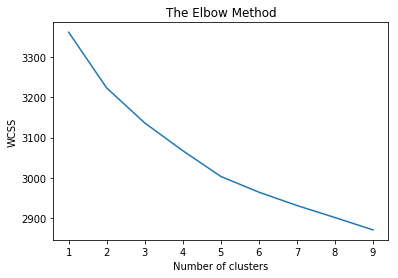

In [28]:
find_number_clusters(tfidf_matrix.todense())

In [133]:
# Apply Kmeans Clustering
km, clusters = apply_kmeans(num_clusters=5,random_state=42,tfidf= tfidf_matrix)

In [20]:
# saving the clustering model
from sklearn.externals import joblib

#uncomment the below to save your model 
#joblib.dump(km,  '5clusters.pkl')
#since I've already run my model I am loading from the pickle
#Uncomment to load the model with 5 clusters
num_clusters = 5
km = joblib.load('5clusters.pkl')
clusters = km.labels_.tolist()

In [21]:
# creating a dataframe which contains additional information about each company
df = pd.read_csv("C:\\Users\\Mr. Priyan\\Dropbox\\Data Science\\DDL\\company_info.csv")
df.sample(5)

,Ticker,Company,Sector,Industry,Country
6354,TOPS,Top Ships Inc.,Services,Shipping,Greece
2706,GHL,"Greenhill & Co., Inc.",Financial,Investment Brokerage - Regional,USA
2714,GIGA,Giga-tronics Inc.,Technology,Scientific & Technical Instruments,USA
6017,SRI,Stoneridge Inc.,Consumer Goods,Auto Parts,USA
5729,SEF,ProShares Short Financials,Financial,Exchange Traded Fund,USA


In [22]:
# Creating a dataframe that contains the company ticker along with the cluster number
df_corpus = pd.DataFrame({'Ticker':corpus.fileids(), 'Clusters':clusters})
df_corpus.head(5)

,Clusters,Ticker
0,3,A-profile.txt
1,3,AA-profile.txt
2,3,AAC-profile.txt
3,3,AAL-profile.txt
4,3,AAMC-profile.txt


In [23]:
# Removing the "-profile.txt" from the Ticker
import re
for i in range(0,len(df_corpus)):
    df_corpus.loc[i,'Ticker']=re.sub("-profile.txt","",df_corpus.loc[i,'Ticker'])
df_corpus.head(5)

,Clusters,Ticker
0,3,A
1,3,AA
2,3,AAC
3,3,AAL
4,3,AAMC


In [24]:
# merging the two dataframe on the Ticker
merged_df = pd.merge(left=df, right=df_corpus, how='inner', on="Ticker")

In [25]:
merged_df.sample(5)

,Ticker,Company,Sector,Industry,Country,Clusters
2710,RLH,Red Lion Hotels Corporation,Services,Lodging,USA,3
2136,MSON,"Misonix, Inc.",Healthcare,Medical Appliances & Equipment,USA,3
2641,QUMU,Qumu Corporation,Technology,Computer Peripherals,USA,3
2900,SKLN,Skyline Medical Inc.,Healthcare,Medical Instruments & Supplies,USA,3
1527,HK,Halcon Resources Corporation,Basic Materials,Oil & Gas Drilling & Exploration,USA,4


In [26]:
# Printing the most recurring Sector(taken from previous dataframe) in each cluster
for i in range(num_clusters):
    print("Cluster",i,":",merged_df[merged_df.Clusters==i].Sector.mode()[0],":- % correct categories is ", \
    round(len(merged_df[merged_df.Clusters==i][merged_df[merged_df.Clusters==i].Sector==\
    merged_df[merged_df.Clusters==i].Sector.mode()[0]])/len(merged_df[merged_df.Clusters==i])*100,2))   

Cluster 0 : Healthcare :- % correct categories is  98.8
Cluster 1 : Financial :- % correct categories is  95.0
Cluster 2 : Financial :- % correct categories is  99.2
Cluster 3 : Services :- % correct categories is  25.94
Cluster 4 : Basic Materials :- % correct categories is  68.84


In [29]:
# Printing terms per cluster
print_cluster(df=merged_df, km=km, num_clusters=num_clusters, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Clusters')

Top terms per cluster:

Cluster 0 words: treatment, clinic, developing, phase, disease,

Cluster 0 Companies: Agenus Inc., Arrowhead Pharmaceuticals, Inc., Galectin Therapeutics, Inc., Flexion Therapeutics, Inc., Accuray Incorporated,

Cluster 1 words: investment, fund, real estate, estate, real,

Cluster 1 Companies: Duke Realty Corporation, InfraREIT, Inc., Eaton Vance Enhanced Equity Income Fund II, Potlatch Corporation, Oxford Lane Capital Corp.,

Cluster 2 words: loans, banks, deposit, accounts, credit,

Cluster 2 Companies: Heritage Commerce Corp., Access National Corporation, Tristate Capital Holdings, Inc., The Bank of South Carolina Corporation, Mercantile Bank Corp.,

Cluster 3 words: retailing, application, technologies, equipment, designs,

Cluster 3 Companies: Entergy Corporation, ON Semiconductor Corp., IDT Corporation, Olin Corp., Paylocity Holding Corporation,

Cluster 4 words: gas, oil, natural gas, natural, energy,

Cluster 4 Companies: Chesapeake Utilities Corporatio

In [30]:
# save cluster topics into a dictionary
topics = save_topics(df=df, km=km, num_clusters=num_clusters, cluster_level='Clusters', num_cluster_topics=10)

In [31]:
# saving cluster topics into a dictionary
#level0 = {'0':'treatment,clinic,disease','1':'invest,fund,real estate','2':'loan, bank, account',\
 #         '3':'retail,application,technology','4':'gas,oil,energy'}

# Splitting clusters 1,3 & 4 into sub-clusters

### Splitting cluster 1


execution time: 0.04 minutes


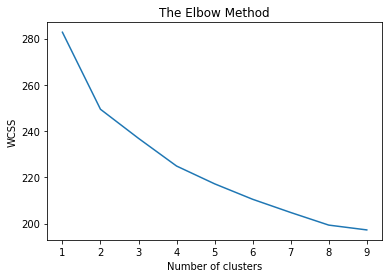

In [33]:
find_number_clusters(cluster1_tfidif.todense())

In [34]:
# trying to find subclusters for any cluster 
Subcluster1_df=merged_df[merged_df['Clusters']==1]
# to get only the indices for this cluster
cluster1_tfidif=tfidf_matrix[Subcluster1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster1_tfidif)
#len(clusters1)
# add new column which includes the numbers of the new clusters
Subcluster1_df = Subcluster1_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster1_df, km=km, num_clusters=2, num_cluster_topics=6, \
 #             num_cluster_companies=5, cluster_level='Subclusters_level_1')
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster1_df.index.values,new_corpus=new_corpus,\
                                                terms=terms,X=2)
print_cluster_words(df=Subcluster1_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: real estate, estate, properties,

Cluster 0 Companies: Pennsylvania Real Estate Investment Trust, Dynex Capital Inc., Retail Opportunity Investments Corp.,

Cluster 1 words: equity, income, stock,

Cluster 1 Companies: Oppenheimer Holdings Inc., Nuveen Tax-Advantaged Total Return Strategy Fund, PennantPark Investment Corporation,

Split of classes within clusters:
0    215
1    145
Name: Subclusters_level_1, dtype: int64


In [35]:
# saving cluster topics into a dictionary
topics.update(save_topics_words(df=Subcluster1_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1', words=X_freq_terms, num_cluster_topics=10))

In [36]:

#level1 = {'10':'real estate,property','11':'equity,income,stock'}

In [37]:
#saving removed topics into a dictionary
removed_topics = {}
removed_topics.update({'1':[unstem(word) for word in X_freq_terms]})

### Splitting the biggest cluster , cluster 3

execution time: 0.46 minutes


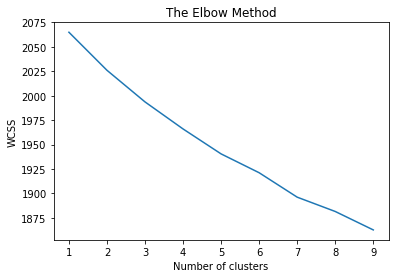

In [39]:
find_number_clusters(cluster3_tfidif.todense())

In [38]:
# trying to find subclusters for any cluster 
Subcluster3_df=merged_df[merged_df['Clusters']==3]
# to get only the indices for this cluster
cluster3_tfidif=tfidf_matrix[Subcluster3_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =10,tfidf = cluster3_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_df = Subcluster3_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_df, km=km, num_clusters=4, num_cluster_topics=6, \
              num_cluster_companies=5, cluster_level='Subclusters_level_1')

Top terms per cluster:

Cluster 0 words: software, data, network, digital, technologies, application,

Cluster 0 Companies: Juniper Networks, Inc., Nationstar Mortgage Holdings Inc., MINDBODY, Inc., Bottomline Technologies (de), Inc., Quantum Corporation,

Cluster 1 words: equipment, power, components, engineering, application, testing,

Cluster 1 Companies: Universal Stainless & Alloy Products Inc., K2M Group Holdings, Inc., Corindus Vascular Robotics Inc., AECOM, Patterson Companies, Inc.,

Cluster 2 words: retailing, food, restaurants, home, care, accessories,

Cluster 2 Companies: Costco Wholesale Corporation, The Hain Celestial Group, Inc., Flowers Foods, Inc., Smart & Final Stores, Inc., The Cato Corporation,

Cluster 3 words: insurance, life, properties, casualty, properties casualty, life insurance,

Cluster 3 Companies: Anthem, Inc., The Travelers Companies, Inc., National General Holdings Corp., CNA Financial Corporation, The Allstate Corporation,

Split of classes within clu

In [40]:
# saving cluster topics into dictionary
topics.update(save_topics(df=Subcluster3_df, km=km, num_clusters=4, cluster_level='Subclusters_level_1', num_cluster_topics=10))

In [272]:
# saving cluster topics into dictionary
#level1.update({'30':'software,data,network','31':'equipment,power,engine','32':'food,restaurant,home',\
 #         '33':'insurance,property,casuality'})

### Splitting cluster 4


execution time: 0.12 minutes


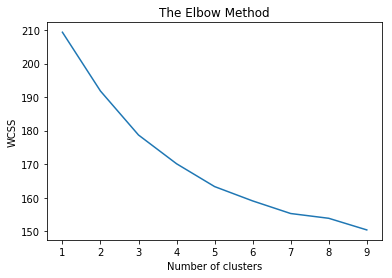

In [184]:
find_number_clusters(tfidf=cluster4_tfidif)

In [41]:
# trying to find subclusters for any cluster 
Subcluster4_df=merged_df[merged_df['Clusters']==4]
# to get only the indices for this cluster
cluster4_tfidif=tfidf_matrix[Subcluster4_df.index.values]
km,clusters = apply_kmeans(num_clusters = 2,random_state =10,tfidf = cluster4_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster4_df = Subcluster4_df.assign(Subclusters_level_1 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster4_df, km=km, num_clusters=2, num_cluster_topics=15, \
 #             num_cluster_companies=5, cluster_level='Subclusters_level_1')

X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster4_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=4)
print_cluster_words(df=Subcluster4_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1',\
                    words=X_freq_terms , num_cluster_topics=10, num_cluster_companies=3)

Top terms per cluster:

Cluster 0 words: natural gas, electrical, pipelines, mile, crude, crude oil, storage, distribution, transportation, generation,

Cluster 0 Companies: Enable Midstream Partners, LP, PPL Corporation, Enbridge Energy Partners, L.P.,

Cluster 1 words: natural gas, oil natural gas, oil natural, oil gas, exploration, basin, reserves, net, barrels, drilling,

Cluster 1 Companies: QEP Resources, Inc., Diamond Offshore Drilling, Inc., Intrepid Potash, Inc.,

Split of classes within clusters:
1    155
0    137
Name: Subclusters_level_1, dtype: int64


In [42]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster4_df, km=km, num_clusters=2, cluster_level='Subclusters_level_1', words =X_freq_terms, num_cluster_topics=10))

In [43]:
#level1.update({'40':'natural gas,electricity,crude oil','41':'barrel,drill'})

In [44]:
#saving removed topics into a dictionary
removed_topics.update({'4':[unstem(word) for word in X_freq_terms]})

In [45]:
#Combining Subclusters and adding into original dataframe
test=pd.concat([Subcluster1_df,Subcluster4_df,Subcluster3_df])
test.drop(['Country','Company','Sector','Industry','Clusters'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

# Creating one more level of sub clusters

### Splitting cluster 3, subcluster 0 into more clusters

execution time: 0.08 minutes


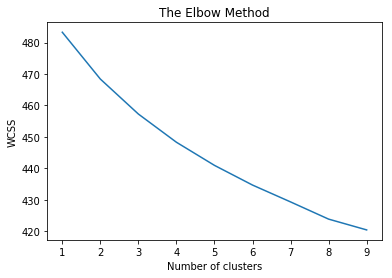

In [47]:
find_number_clusters(Subcluster3_level1_0_tfidif.todense())

In [46]:
# trying to find subclusters for any cluster 
Subcluster3_level1_0_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==0)]
# to get only the indices for this cluster
Subcluster3_level1_0_tfidif=tfidf_matrix[Subcluster3_level1_0_df.index.values]
km,clusters = apply_kmeans(num_clusters = 4,random_state =42,tfidf = Subcluster3_level1_0_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_0_df = Subcluster3_level1_0_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
print_cluster(df=Subcluster3_level1_0_df, km=km, num_clusters=4, num_cluster_topics=5, \
              num_cluster_companies=5, cluster_level='Subclusters_level_2')

Top terms per cluster:

Cluster 0 words: payment, technologies, financial, information, online,

Cluster 0 Companies: Career Education Corp., Heidrick & Struggles International Inc., American Public Education, Inc., MasterCard Incorporated, Nationstar Mortgage Holdings Inc.,

Cluster 1 words: wireless, communities, network, video, voice,

Cluster 1 Companies: Gogo Inc., RELM Wireless Corp., Best Buy Co., Inc., Vonage Holdings Corporation, Sonic Foundry, Inc.,

Cluster 2 words: software, data, cloud, application, enterprise,

Cluster 2 Companies: Finjan Holdings, Inc., SS&C Technologies Holdings, Inc., salesforce.com, inc., Qualys, Inc., QAD Inc.,

Cluster 3 words: digital, content, advertising, media, television,

Cluster 3 Companies: Comcast Corporation, Sinclair Broadcast Group, Inc., Hemisphere Media Group, Inc., Daktronics Inc., Bridgeline Digital, Inc.,

Split of classes within clusters:
2    170
0    153
1    119
3    113
Name: Subclusters_level_2, dtype: int64


In [48]:
# saving cluster topics into dictionary
topics.update(save_topics(df=Subcluster3_level1_0_df, km=km, num_clusters=4, cluster_level='Subclusters_level_2', num_cluster_topics=10))

In [278]:
#level2 = {'300':'payment,finance,online','301':'wireless,communication,video','302':'data,cloud,enterprise',\
 #         '303':'digital,advertise,media'}

### Splitting cluster 3, subcluster 1 into more clusters

execution time: 0.1 minutes


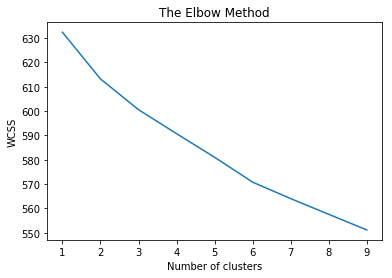

In [50]:
find_number_clusters(Subcluster3_level1_1_tfidif.todense())

In [49]:
Subcluster3_level1_1_df=merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==1)]
Subcluster3_level1_1_tfidif=tfidf_matrix[Subcluster3_level1_1_df.index.values]
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_1_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_1_df = Subcluster3_level1_1_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster3_level1_1_df, km=km, num_clusters=3, num_cluster_topics=5, \
#              num_cluster_companies=3, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_1_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=10)
print_cluster_words(df=Subcluster3_level1_1_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=4, num_cluster_companies=2)

Top terms per cluster:

Cluster 0 words: medical, diagnostics, surgical, instruments,

Cluster 0 Companies: Thermo Fisher Scientific, Inc., Medovex Corp.,

Cluster 1 words: electronic, semiconductor, optical, aerospace,

Cluster 1 Companies: Intricon Corp., Analog Devices, Inc.,

Cluster 2 words: construction, materials, electrical, chemical,

Cluster 2 Companies: Boise Cascade Company, KMG Chemicals Inc.,

Split of classes within clusters:
2    386
1    166
0    154
Name: Subclusters_level_2, dtype: int64


In [51]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster3_level1_1_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2', num_cluster_topics=10,words=X_freq_terms))

In [52]:
# saving cluster topics into dictionary
#level2.update({'310':'medical,diagnostic,surgical','311':'electronics,semiconductor,optical','312':'construction,chemical'})

In [53]:
#saving removed topics into a dictionary
removed_topics.update({'31':[unstem(word) for word in X_freq_terms]})

### Splitting cluster 3, subcluster 2 into more clusters

execution time: 0.13 minutes


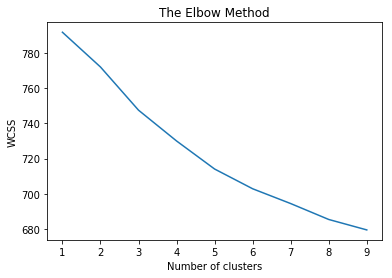

Top terms per cluster:

Cluster 0 words: food, care, health,

Cluster 0 Companies: Advanced Disposal Services South, LLC, Steelcase Inc., Vista Gold Corp.,

Cluster 1 words: accessories, apparel, women,

Cluster 1 Companies: Kohl's Corp., Christopher & Banks Corporation, Fossil Group, Inc.,

Cluster 2 words: restaurants, franchised, operational,

Cluster 2 Companies: El Pollo Loco Holdings, Inc., GrubHub Inc., Texas Roadhouse, Inc.,

Split of classes within clusters:
0    663
1    137
2     44
Name: Subclusters_level_2, dtype: int64


In [54]:
# trying to find subclusters for any cluster 
Subcluster3_level1_2_df = merged_df[(merged_df['Clusters']==3) & (merged_df['Subclusters_level_1']==2)]
Subcluster3_level1_2_tfidif=tfidf_matrix[Subcluster3_level1_2_df.index.values]

find_number_clusters(Subcluster3_level1_2_tfidif.todense())
km,clusters = apply_kmeans(num_clusters = 3,random_state =42,tfidf = Subcluster3_level1_2_tfidif)
# add new column which includes the numbers of the new clusters
Subcluster3_level1_2_df = Subcluster3_level1_2_df.assign(Subclusters_level_2 = clusters)
# Printing terms per cluster
#print_cluster(df=Subcluster3_level1_2_df, km=km, num_clusters=3, num_cluster_topics=5, \
#              num_cluster_companies=5, cluster_level='Subclusters_level_2')
#removing X most frequent terms from parent cluster
X_freq_terms, freq_terms_with_count = freq_words(indexes=Subcluster3_level1_2_df.index.values,new_corpus=new_corpus,\
                                                 terms=terms,X=2)
print_cluster_words(df=Subcluster3_level1_2_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2',\
                    words=X_freq_terms , num_cluster_topics=3, num_cluster_companies=3)

In [55]:
# saving cluster topics into dictionary
topics.update(save_topics_words(df=Subcluster3_level1_2_df, km=km, num_clusters=3, cluster_level='Subclusters_level_2', num_cluster_topics=10,words=X_freq_terms))

In [56]:
# saving cluster topics into dictionary
#level2.update({'320':'food,care,health','321':'accessories,apparel,women','322':'restaurant,franchise'})

In [57]:
#saving removed topics into a dictionary
removed_topics.update({'32':[unstem(word) for word in X_freq_terms]})

In [58]:
test=pd.concat([Subcluster3_level1_1_df,Subcluster3_level1_2_df,Subcluster3_level1_0_df])
test.drop(['Country','Company','Sector','Industry','Clusters','Subclusters_level_1'], axis=1, inplace=True)
merged_df = pd.merge(left=merged_df, right=test, how='left', on="Ticker")

 #check if new_merged_df is correct, if so then rename it to merged_df
merged_df.columns = ['Ticker', 'Company', 'Sector', 'Industry', 'Country', 'Clusters Level 0','Clusters Level 1', \
                         'Clusters Level 2']
#temp = merged_df[merged_df['Clusters Level 0']==3]
#temp = temp[temp['Clusters Level 1']==3]
#temp = temp[temp['Clusters Level 2']==3].info()



---

In [59]:
# See the dataframe with the 3 levels, level 0, level 1 and level 2
merged_df

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,3,1.0,0.0
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA,3,2.0,0.0
2,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,3,2.0,0.0
3,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,3,2.0,0.0
4,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,3,2.0,0.0
5,AAME,Atlantic American Corp.,Financial,Life Insurance,USA,3,3.0,NaN
6,AAN,"Aaron's, Inc.",Services,Rental & Leasing Services,USA,3,2.0,1.0
7,AAOI,"Applied Optoelectronics, Inc.",Technology,Semiconductor - Integrated Circuits,USA,3,1.0,1.0
8,AAON,AAON Inc.,Industrial Goods,General Building Materials,USA,3,1.0,2.0
9,AAP,Advance Auto Parts Inc.,Services,Auto Parts Stores,USA,3,1.0,2.0


### dataframe showing the topics

In [60]:
# copy the dataframe to a new one (has its own values)
temp_df = merged_df.copy(deep=True)

In [61]:
## adding topics into the dataframe
temp_df['Clusters Level 0'] = temp_df['Clusters Level 0'].astype(object)
temp_df['Clusters Level 1'] = temp_df['Clusters Level 1'].astype(object)
temp_df['Clusters Level 2'] = temp_df['Clusters Level 2'].astype(object)

for key in topics:
    if len(key)==3:
        l0=key[0]
        l1=key[1]
        l2=key[2]
        
        test = temp_df[(temp_df['Clusters Level 0']==int(l0)) & (temp_df['Clusters Level 1']==int(l1)) & (temp_df['Clusters Level 2']==int(l2))]                   
        for ind in test.index.values:
            temp_df.at[ind,'Clusters Level 2'] =topics[key]
for key in topics:
    if len(key)==2:
        l0=key[0]
        l1=key[1]
               
        test = temp_df[(temp_df['Clusters Level 0']==int(l0)) & (temp_df['Clusters Level 1']==int(l1))]                   
        for ind in test.index.values:
            temp_df.at[ind,'Clusters Level 1'] =topics[key]
for key in topics:
    if len(key)==1:        
        test = temp_df[temp_df['Clusters Level 0']==int(key)]
        for i in test.index.values:
            temp_df.at[i,'Clusters Level 0'] = topics[key]


In [63]:
#Dataframe showing all hierarchical topics
temp_df

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2
0,A,"Agilent Technologies, Inc.",Healthcare,Medical Laboratories & Research,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[medical, diagnostics, surgical, instruments, ..."
1,AA,Alcoa Inc.,Basic Materials,Aluminum,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
2,AAC,"AAC Holdings, Inc.",Healthcare,Specialized Health Services,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
3,AAL,American Airlines Group Inc.,Services,Major Airlines,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
4,AAMC,Altisource Asset Management Corporation,Financial,Asset Management,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
5,AAME,Atlantic American Corp.,Financial,Life Insurance,USA,"[retailing, application, technologies, equipme...","[insurance, life, properties, casualty, proper...",NaN
6,AAN,"Aaron's, Inc.",Services,Rental & Leasing Services,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[accessories, apparel, women, merchandisers, s..."
7,AAOI,"Applied Optoelectronics, Inc.",Technology,Semiconductor - Integrated Circuits,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[electronic, semiconductor, optical, aerospace..."
8,AAON,AAON Inc.,Industrial Goods,General Building Materials,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[construction, materials, electrical, chemical..."
9,AAP,Advance Auto Parts Inc.,Services,Auto Parts Stores,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[construction, materials, electrical, chemical..."


In [64]:
temp_df.sample(25)

,Ticker,Company,Sector,Industry,Country,Clusters Level 0,Clusters Level 1,Clusters Level 2
2184,NBHC,National Bank Holdings Corp.,Financial,Regional - Midwest Banks,USA,"[loans, banks, deposit, accounts, credit, esta...",NaN,NaN
1416,GPI,Group 1 Automotive Inc.,Services,Auto Dealerships,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
552,CBAN,Colony Bankcorp Inc.,Financial,Regional - Mid-Atlantic Banks,USA,"[loans, banks, deposit, accounts, credit, esta...",NaN,NaN
507,BXP,Boston Properties Inc.,Financial,REIT - Office,USA,"[investment, fund, real estate, estate, real, ...","[real estate, estate, properties, real, trust,...",NaN
3403,WAFD,"Washington Federal, Inc.",Financial,Savings & Loans,USA,"[loans, banks, deposit, accounts, credit, esta...",NaN,NaN
1655,IMGN,"ImmunoGen, Inc.",Healthcare,Biotechnology,USA,"[treatment, clinic, developing, phase, disease...",NaN,NaN
2894,SIX,Six Flags Entertainment Corporation,Services,General Entertainment,USA,"[retailing, application, technologies, equipme...","[retailing, food, restaurants, home, care, acc...","[food, care, health, based, water, beverage, d..."
1415,GPC,Genuine Parts Company,Services,"Specialty Retail, Other",USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[construction, materials, electrical, chemical..."
1186,FBNC,First Bancorp,Financial,Regional - Mid-Atlantic Banks,USA,"[loans, banks, deposit, accounts, credit, esta...",NaN,NaN
1209,FEIM,Frequency Electronics Inc.,Technology,Communication Equipment,USA,"[retailing, application, technologies, equipme...","[equipment, power, components, engineering, ap...","[electronic, semiconductor, optical, aerospace..."


In [65]:
# Showing the topics removed from the clusters
removed_topics

{'1': ['investment', 'fund'],
 '31': ['equipment',
  'power',
  'application',
  'engineering',
  'designs',
  'control',
  'components',
  'technologies',
  'testing',
  'devices'],
 '32': ['retailing', 'home'],
 '4': ['gas', 'oil', 'natural', 'energy']}

---

In [139]:
# rough work
# to find the 1st common term for cluster 0
#terms[order_centroids[0,0]]
#merged_df[merged_df['Clusters']==i]["Company"][0:5].values.tolist()
#order_centroids shape is 4x360 ie., 360 features from tdidf and 4 clusters from KNN
#terms[order_centroids[0,14]]
#import random    
#my_randoms=[]    
#for i in range (10):    
    #my_randoms.append(random.randrange(1,3559,1))    
    #print (my_randoms)  
#my_randoms
#title1 = merged_df[merged_df['Clusters']==0]["Company"].sample(1).values.tolist()
#merged_df.Sector[merged_df.Company=="Independent Bank Corporation"].values[0]
# Take separate dataframe according to each cluster
#Cluster0=merged_df[merged_df.Clusters==0]
#Cluster1=merged_df[merged_df.Clusters==1]
#Cluster2=merged_df[merged_df.Clusters==2]
#Cluster3=merged_df[merged_df.Clusters==3]
#print("Cluster0:",Cluster0.Sector.mode()[0],":- % correct categories is ",round(len(Cluster0[Cluster0.Sector==Cluster0.Sector.mode()[0]])/len(Cluster0)*100,2))
#print("Cluster1:",Cluster1.Sector.mode()[0],":- % correct categories is ",round(len(Cluster1[Cluster1.Sector==Cluster1.Sector.mode()[0]])/len(Cluster1)*100,2))
#print("Cluster2:",Cluster2.Sector.mode()[0],":- % correct categories is ",round(len(Cluster2[Cluster2.Sector==Cluster2.Sector.mode()[0]])/len(Cluster2)*100,2))
#print("Cluster3:",Cluster3.Sector.mode()[0],":- % correct categories is ",round(len(Cluster3[Cluster3.Sector==Cluster3.Sector.mode()[0]])/len(Cluster3)*100,2))
#print() #add whitespace
#print() #add whitespace

In [588]:
# adding level0 topics to dataframe
## need to change this to deal with a single dictionary
#for key in level0:
    #l=key
    #test = temp_df[temp_df['Clusters Level 0']==int(l)]
    #for i in test.index.values:
        #temp_df.loc[i,'Clusters Level 0'] =level0[l]
# adding level1 topics to dataframe
#for key in level1:
    #l0=key[0]
    #l1=key[1]
    #test = temp_df[(temp_df['Clusters Level 0']==level0[l0]) & (temp_df['Clusters Level 1']==int(l1))]
    #for i in test.index.values:
        #temp_df.loc[i,'Clusters Level 1'] =level1[key]
# adding level2 topics to dataframe
#for key in level2:
    #l0=key[0]
    #l1=key[1]
    #l2=key[2]
    #test = temp_df[(temp_df['Clusters Level 0']==level0[l0]) & \
                   #(temp_df['Clusters Level 1']==level1[l0+l1]) & (temp_df['Clusters Level 2']==int(l2))]
    #for i in test.index.values:
        #temp_df.loc[i,'Clusters Level 2'] =level2[key]